In [4]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [5]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

In [6]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
aas = ''.join(sorted(df0['seq']))
print(len(aas), aas)

20 ACDEFGHIKLMNPQRSTVWY


In [30]:
def energy(s, h, Jk):
    energy = sum(h[c] for c in s)
    for k, J in enumerate(Jk):
        for i in range(len(s)-1):
            energy += J[s[i]][s[i+k+1]]
    return -energy

In [10]:
def expfamily(seq, lambdas, fs, Z=1):
    return np.exp(np.sum(lambdas*np.array([f(seq) for f in fs])))/Z

In [11]:
def create_counter(s):
    return lambda seq: seq.count(s)

In [12]:
symbols = aas
lambdas = np.zeros(len(aas))/len(aas)
fs = [create_counter(s) for s in list(symbols)]
abcd = expfamily('ABCD', lambdas, fs)

In [13]:
Z = sum(expfamily(s, lambdas, fs) for s in itertools.product(symbols, repeat=4))
print(Z, abcd/Z, 1/20**4)

160000.0 6.25e-06 6.25e-06


In [114]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
df0 = df0.set_index('seq')
humanaaprobdict = np.log(df0['freq']).to_dict()
humanaaprobdict

df1 = counter_to_df(counters[1], norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = (1e-100*count).to_dict()

In [115]:
h = humanaaprobdict
Jk = [humandoubletprobdict]

In [116]:
Z = sum(np.exp(-energy(s, h, Jk)) for s in itertools.product(symbols, repeat=4))

In [125]:
np.exp(-energy('WWWW', h, Jk))/Z

2.2047372031526217e-08

In [124]:
np.exp(loglikelihood_independent('WWWW', humanaaprobdict))

2.2047085068629296e-08

In [232]:
def mcmcsampler(x0, energy, jump, nsteps, nburnin=0, nsample=1):
    nsteps, nburnin, nsample = int(nsteps), int(nburnin), int(nsample)
    x = x0
    Ex = energy(x)
    states = []
    for i in range(nsteps):
        xp = jump(x)
        Exp = energy(xp)
        #print(np.exp(-Exp)/np.exp(-Ex))
        if np.random.rand() < np.exp(-Exp+Ex):
            x = xp
            Ex = Exp
            if i > nburnin:
                states.append(x)
#        if (i > nburnin) and (i % nsample == 0):
#            states.append(x)
    return np.array(states)

In [239]:
aafreqs = np.array(df0.loc[np.array(list(aas))]['freq'])
aafreqs /= np.sum(aafreqs)
jump = lambda x: ''.join(np.random.choice(np.array(list(aas)), size=4))
x0 = jump(None)
samples = mcmcsampler(x0, lambda x: energy(x, h, Jk), jump, 1e6, 1e3)

In [240]:
dfm = df0.merge(counter_to_df(count_kmers_iterable(samples, 1)), left_index=True, right_on='seq')

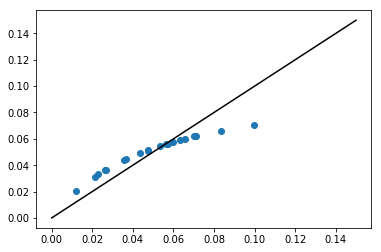

In [241]:
x = np.linspace(0.0, 0.15)
plt.plot(x, x, 'k')
plt.scatter(dfm['freq_x'], dfm['freq_y'])